## SDE Diffusion
### Introduction
本文的目的是梳理最近学习的sde, score model和diffusion，全文参考[Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/#mjx-eqn%3Aebm)。

**由于当前处于入门水平，本文可能存在错误**:
1. **去噪扩散概率模型**: DDPM从变分和贝叶斯的角度出发提出**去噪扩散概率模型**，该模型主要分为两个步骤：
    - 前向扩散：主要是利用iid高斯分布逐步将真实图像破坏为纯粹的高斯噪声$\mathcal N(0, I)$，这也成为先验分布
    - 逆向扩散：即从纯高斯噪声出发，逐步去噪，最终生成样本。
2. **多噪声尺度的分数生成模型**： Song等人早期使用Score模型来研究生成任务，通过score-matching训练分数模型，然后通过Langebin dynamics生成样本。然而，这种方式在实际中作用有限。主要原因在低密度区域（可用于计算得分匹配目标的数据点少）估计的分数模型是不准确的。为了解决该问题，他们提出用多尺度的噪声$\sigma_1 <\sigma_2<\cdots < \sigma_L$来填充低密度区域以提高估计的准确性。这种策略在一程度上与DDPM类似。
3. **SDE Diffusion**：Song等的工作表明DDPM的前向扩散或者用噪声扰动原始数据分布的过程是**随机过程**，并用随机方程来表示前向扩散过程，使用SDE求解器来进行采样。并且可以选择不同的随机方程，从而能够推导到以上两个工作，从而揭示了这几个工作的联系。

### Score and SDE
给定一个概率密度函数$p(\mathbf x)$，可以定义其**score**（分数或得分）为:

$$
\nabla_{\mathbf x}\log p(\mathbf x)
$$

**Score-based generative models**（分数生成模型）被**训练**用于估计$\nabla_{\mathbf x}\log p(\mathbf x)$，与**基于似然的模型**不同，分数模型**不必进行归一化**或**被简单地参数化**。原因是被用于归一化的分布或积分是难以计算的。基于似然的模型是直接对PDF或PMF建模。让$f_\theta(\mathbf x)\in \mathbb R$表示为一个**由可学习的参数$\theta$参数化的实值函数**，可以通过以下方式定义PDF：

$$
p_\theta(\mathbf x) = \frac{e^{-f_\theta(\mathbf x)}}{Z_\theta}
$$

其中，$Z_\theta > 0$是一个取决于$\theta$的**归一化常数**，$\int p_\theta(\mathbf x)d\mathbf x=1$。这里的$f_\theta(\mathbf x)$通常称为**非归一化概率模型**或**基于能量的模型**。**实际上$Z_\theta$通常是难以计算的**。通过计算其分数（梯度），可以忽略该归一化系数:

$$
\begin{aligned}
s_\theta(\mathbf x) &= \nabla_{\mathbf x}\log p_\theta(\mathbf x)\\
&=\frac{\partial \log (\frac{e^{-f_\theta(\mathbf x)}}{Z_\theta})}{\partial \mathbf x}\\
&= -\nabla_{\mathbf x}f_\theta(\mathbf x) - \underbrace{\nabla_{\mathbf x}\log Z_\theta}_{=0}\\
&=-\nabla_{\mathbf x}f_\theta(\mathbf x)
\end{aligned}
$$

事实上，任何将输入变量$\mathbf x \in \mathbb R^{d}$映射到输出向量$\mathbf y \in \mathbb R^d$的神经网络都可以用作基于分数的模型，**只要输入和输出具有相同的维度**，这为选择模型架构带来了巨大的灵活性。

#### Perturbing Data with a Diffusion Process
为了用分数模型生成样本，需要考虑**扩散过程**缓慢地将数据破坏为随机噪声。**与布朗运动类似，扩散过程是是一个随机过程**。假设$\{\mathbf x(t)\in \mathbb R^d\}_{t=0}^T$是一个扩散过程，并由连续时间变量$t\in [0, T]$索引。扩散过程被随机微分方程（SDE）主导：

$$
d\mathbf x = f(\mathbf x, t) dt + g(t)d\mathbf w
$$
其中，$f(\cdot, t):\mathbb R^d \rightarrow \mathbb R^d$被称为SDE的**drift**（飘移）系数，$g(t)\in \mathbb R$被称为**扩散系数**，$\mathbf w$表示标准的布朗运动。*可以将SDE理解为ODE的随机推广，随着SDE移动的粒子不仅遵循确定性飘移$f(\mathbf x, t)$，而且还受到来自$g(t)d\mathbf w$随机噪声的影响*。现在使用$p_t(\mathbf x)$来表示$\mathbf x(t)$的分布。

为了分数生成模型建模，选择$\mathbf x(0)\sim p_0, \mathbf x(T)\sim p_T$。其中，$p_0$是原始数据分布，其中有一个**独立同分布的数据集**。$p_T$是**先验分布**，**具有易于处理的形式并且易于从中采样**。扩散过程中的**噪声扰动足够大，以确保$p_T$不依赖于$p_0$**。


#### Reversing the Diffusion Process Yeilds Score-Based Generative Models
从先验分布$p_T$出发并反向**扩散过程**，将能够从数据分布$p_0$中获得样本。反向过程由逆向SDE给出：

$$
d\mathbf x = [f(\mathbf x, t) - g^2(t)\nabla_{\mathbf x}\log p_t(\mathbf x)]dt + g(t)d\bar{\mathbf w}
$$

其中，$\bar{\mathbf w}$是反向的布朗运动，$d_t$是无穷小的时间步长。一旦知道了**前向SDE**的**飘移系数**和**扩散系数**，以及每个时刻$t\in [0, T]$的$p_t(\mathbf x)$的分数，就可以计算该反向SDE.

#### Score Estimation
基于以上分析，可以使用**time-dependent**分数函数$\nabla_{\mathbf x}\log p_t(\mathbf x)$来构造**reverse-time SDE**，然后使用先验分布$p_T$的样本对其进行数值求解已从$p_0$获得样本。因此，可以使用以下去噪分数匹配目标的加权和来训练基于时间的分数模型$s_\theta(\mathbf x, t)$来近似$\nabla_{\mathbf x}\log p_t(\mathbf x)$:

$$
\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
$$

其中，$\mathcal U(0, T)$是$[0, T]$上的均匀分布，$p_{0t}(\mathbf x(t)|\mathbf x(0))$表示从$\mathbf x(0)$到$\mathbf x(t)$的**转移概率**，$\lambda(t)\in \mathbb R_{>0}$表示**正加权函数**。在这个目标中，$\mathbf x(0)$的期望可以使用来自$p_0$数据样本的经验平均值来估计，$\mathbf x(t)$的期望可以通过从$p_{0t}(\mathbf x(t)|\mathbf x(0))$中采样估计。当飘移系数$f(\mathbf x, t)$是仿射时，这是有效地。权重函数$\lambda(t)$通常选择为与$\mathbb E[\|\nabla_{\mathbf x}\log p_{0t}(\mathbf x(t)|\mathbf x(0))\|_2^2]$成反比。

#### Time-Dependent Score-Based Model

时间相关的分数生成模型对网络架构没有限制，只需要输入和输出的维度相同，并且**以时间为条件**。

关于模型选择的tips:
- 通常选择U-Net架构作为分数模型(网络)$s_\theta(\mathbf x, t)$的backbone
- 能够通过**高斯随机特征**来融入时间信息。特别地，首先采样$\omega \sim \mathcal N(0, s^2I)$，随后将其固定为模型（即不可学习）。对于每个时间步$t$，对应的高斯随机特征定义如下：

    $$
     [\sin(2\pi\omega t);\cos(2\pi\omega t)]
    $$
  其中$[\vec a;\vec b]$表示向量$\vec a$和$\vec b$的**串联**。该高斯随机特征可以用作时间步长$t$的编码，以便分数模型能够通过合并该编码来以$t$为条件
- 能够通过$1 / \sqrt{\mathbb E[\|\nabla_{\mathbf x} \log p_{0t}(\mathbf x(t)|\mathbf x(0))\|_2^2]}$来重新缩放U-Net的输出。这是因为最优$s_\theta(\mathbf x(t), t)$的$\mathcal l_2$范数接近$\mathbb E[\|\nabla_{\mathbf x} \log p_{0t}(\mathbf x(t)|\mathbf x(0))\|_2]$，并且重新缩放有助于捕捉真实分数的范数。这将很自然的期望最优的分数模型$s_\theta(\mathbf x, t)\approx \nabla_{\mathbf x(t)} \log p_{0t}(\mathbf x(t)|\mathbf x(0))$。
- 当采样时使用权重的EMA，这可以极大地提高样本质量，但需要的训练时间稍长。


### 实现
#### 网络结构和时间嵌入
具体的代码参考[Tutorial on Score-Based Generative Modeling (PyTorch)](https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=qW1HaPZb9gDM)

#### 基于SDE的Diffusion
在SDE视角下，我们首先要指定一个SDE，然后将原始数据$p_0$扰乱为先验分布$p_T$。简单地选择如下形式的随机方程：

$$
d\mathbf x = \sigma^t d\mathbf w, t\in [0, 1]
$$
其中，$\mathbf w$表示为高斯白噪声。

In [7]:
import torch
import numpy as np

def diffusion_coeff(t, sigma, device='cpu'):
    """计算给定SDE的扩散系数，飘移系数为0无需计算"""
    return torch.tensor(sigma ** t, device=device)

#### 前向扩散过程
在给定SDE具体形式的情况下，我们**同时对SDE两边进行积分**

$$
\begin{aligned}
\int_0^t d\mathbf x(s) &= \int_0^t \sigma^s d\mathbf w(s) \\
\mathbf x(t) - \mathbf x(0) &= \int_0^t \sigma^s d\mathbf w(s)
\end{aligned}
$$
由于$d\mathbf w(s)$是标准的布朗运动，它是独立正太分布的，可以计算方差：

$$
\text{Var}\left[\int_0^t \sigma^s d\mathbf w(s)\right] = \int_0^t \sigma^{2s}ds = \frac{\sigma^{2t} - 1}{2\log \sigma}
$$

所以

$$
\begin{aligned}
p_{0t}(\mathbf{x}(t)|\mathbf{x}(0)) &= \mathcal{N}\left(\mathbf{x}(t)|\mathbf{x}(0), \frac{\sigma^{2t} - 1}{2\log \sigma}\mathbf{I}\right) \\
\mathbf{x}(t) &= \mathbf{x}(0) + \sqrt{\frac{\sigma^{2t} - 1}{2\log \sigma}} \mathbf{I} \cdot \mathcal{N}(0, \mathbf{I})
\end{aligned}
$$

当$\sigma$足够大时，先验分布$p_{t=1}$将近似为

$$
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg)
$$

基于此，我们可以得到前向过程的方差变化情况，并且可以按照该方式来更新$t$时刻被扰动的数据。

In [8]:
def marginal_prob_std(t, sigma, device='cpu'):
    """计算前向过程中t时刻的标准差"""
    t = torch.tensor(t, device=device)
    std = torch.sqrt((sigma ** (2 * t) - 1) / (2. * np.log(sigma)))
    return std

模拟前向扩散过程如下

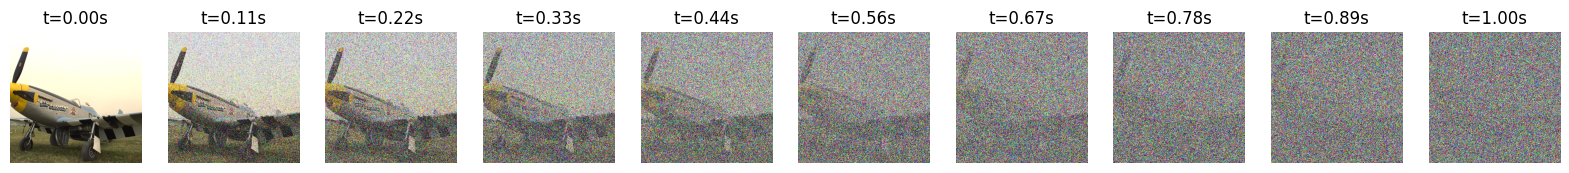

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(Image.open("D:/TestDataSet/Kodak24/kodim20.png"))
image = np.float32(image / 255.)
h, w, c = image.shape
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for ax, t in zip(axes, np.linspace(0, 1, 10)):
    std = marginal_prob_std(t, sigma=25)
    noised = image + np.random.randn(h, w, c) * std.data.numpy()
    ax.imshow(noised.clip(0, 1)), ax.axis('off'), ax.set_title(f't={t:.2f}s')

#### 损失函数

在**Score Estimation**中介绍了用于指导训练的通用损失函数为：

$$
\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
$$

其中，$s_\theta(\mathbf x, t)$是**待训练的网络模型**，我们在**前向扩散过程**中基于给定的SDE确定了$p_{0t}(\mathbf x(t)|\mathbf x(0))$的具体形式：

$$
\begin{aligned}
p_{0t}(\mathbf x(t)|\mathbf x(0)) &=\mathcal N\left(\mathbf x(t)|\mathbf x(0), \frac{\sigma^{2t} - 1}{2\log \sigma}\mathbf I\right)\\
\end{aligned}
$$
因此，可得

$$
\begin{aligned}
\nabla_{\mathbf x(t)}p_{0t}(\mathbf x(t)|\mathbf x(0)) &= \frac{\partial}{\partial \mathbf x(t)} \log\left(\frac{1}{\sqrt{2\pi}\beta}\cdot \exp \frac{-(\mathbf x(t) - \mathbf x(0))^2}{2\beta^2}\right)\\
&=\frac{\mathbf x(0) - \mathbf x(t)}{\beta^2}
\end{aligned}
$$
其中，$\beta$是为了方便书写的临时变量，$\beta^2 = \frac{\sigma^{2t} - 1}{2\log \sigma}$。基于此，**损失函数**重写为：

$$
\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \frac{\mathbf x(0) - \mathbf x(t)}{\beta^2}\|_2^2]],
\end{align}
$$

其中，$\lambda(t)$是一个正权重函数。**为了确保损失函数值在不同时刻下保持平衡**，将$\lambda(t)\propto 1 / \mathbb E[\|\nabla_{\mathbf x(t)}\log p(\mathbf x(t)|\mathbf x(0))\|^2_2]$。**具体时间中，$\lambda(t) = \beta^2 = \frac{\sigma^{2t} - 1}{2\log \sigma}$**，使得

$$
\begin{aligned}
&\ \ \ \ \lambda(t) \left\|s_\theta(\mathbf{x}(t), t) - \frac{\mathbf x(0) - \mathbf x(t)}{\beta^2}\right\|_2^2 \\
&=\beta^2\left\|s_\theta(\mathbf{x}(t), t) - \frac{\mathbf x(0) - \mathbf x(t)}{\beta^2}\right\|_2^2 \\
&=\left\|\beta s_\theta(\mathbf{x}(t), t) + \frac{\mathbf x(t) - \mathbf x(0)}{\beta}\right\|_2^2\\
\end{aligned}
$$
加上，我们在前向扩散过程得到的

$$
\begin{aligned}
\mathbf{x}(t) &= \mathbf{x}(0) + \sqrt{\frac{\sigma^{2t} - 1}{2\log \sigma}} \cdot \mathcal{N}(0, \mathbf{I}) \
&= \mathbf{x}(0) + \beta\cdot \mathcal{N}_t(0, \mathbf{I})
\end{aligned}
$$
最终可以得到训练过程中的损失函数为：

$$
\begin{aligned}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}\left[ \left\|\beta s_\theta(\mathbf{x}(t), t) + \mathcal N_{t}(0, I)\right\|_2^2\right],
\end{aligned}
$$

In [10]:
def loss_fn(model, x, maginal_prob_std, eps=1e-5):
    # eps: a tolerance value for numerical stability.
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    noise = torch.randn_like(x)
    beta = maginal_prob_std(random_t)
    perturbed_x = x + beta[:, None, None, None] * noise
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * beta[:, None, None, None] + noise) ** 2, dim=(1, 2, 3)))
    return loss

#### 训练分数模型

In [11]:
import tqdm
import torch
import functools
import torchvision.transforms as transforms

from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# score网络模型：U-Net
from score_model import ScoreNet 

sigma = 25.0
device = 'cuda'
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

In [6]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

optimizer = Adam(score_model.parameters(), lr=1e-4)
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

tqdm_epoch = tqdm.notebook.trange(50)
for epoch in tqdm_epoch:
    avg_loss, num_items = 0., 0.
    for x, y in data_loader:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\LiangHao\AppData\Local\Temp\ipykernel_21764\341079553.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


#### 后向扩散过程
训练分数模型之后，就是测试时的采样过程。在前面用SDE表示扩散模型时，前向SDE过程为：

$$
d\mathbf x = f(\mathbf x, t)dt + g(t)d\mathbf w
$$

后向（逆）SDE表示为:

$$
d\mathbf x = [f(\mathbf x, t) - g(t)^2\nabla_{\mathbf x}\log p_t(\mathbf x)]dt + g(t)d\bar{\mathbf w}
$$

由于在前面选择了一个简单的SDE：

$$
d\mathbf x = \sigma^t d\mathbf w, t\in [0, 1]
$$

其飘移系数为0，所以其反向SDE表示为：

$$
\begin{aligned}
d\mathbf x &=-\sigma^{2t}\nabla_{\mathbf x}\log p_t(\mathbf x)dt + \sigma^td\bar{\mathbf w}\\
&= -\sigma^{2t}s_\theta(\mathbf x, t) + \sigma^t d\bar{\mathbf w}
\end{aligned}
$$

##### Sampling with Numerical SDE Solvers

为了从分数模型$s_\theta(\mathbf x, t)$从采样:
1. 首先从先验分布$p_1\approx \mathbf N(\mathbf x; 0, \frac{1}{2\log\sigma}(\sigma^2 - 1)I$中采样
2. 然后利用**数值方法求解反向SDE**。这里使用的Eluer-Maruyama方法，将$dt$替换为$\Delta t$，$\mathbf z \sim \mathcal N(0, g^2(t)\Delta t I)$替代$d\bar{\mathbf w}$来对连续的SDE进行离散化。最后得到如下的采样过程：

$$
\begin{aligned}
\mathbf x_{t-\Delta t} &= \mathbf x_t + \sigma^{2t}s_\theta(\mathbf x_t, t)\Delta t + \sigma^t\sqrt{\Delta t}\mathbf z_t\\
&= \mathbf x_t + (\underbrace{\sigma^t}_{g(t)})^2\cdot s_\theta(\mathbf x_t, t)\cdot \underbrace{\Delta t}_{step size} + \sigma^t\sqrt{\Delta t}\cdot \underbrace{\mathbf z_t}_{\mathcal N(0, \mathbf I)}
\end{aligned}
$$

其中，$\mathbf z_t \sim \mathcal N(0, I)$



In [12]:
@torch.no_grad()
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size =64, 
                           num_steps=500,
                           device='cuda',
                           eps=1e-3
                           ):
    t = torch.ones(batch_size, device=device)
    # 1. 从先验分布中采样
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    # t=1 -> t=0
    time_steps = torch.linspace(1, eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    # 2. 数值SDE求解器采样
    for time_step in tqdm.notebook.tqdm(time_steps):
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        g = diffusion_coeff(batch_time_step)
        
        mean_x = x + (g ** 2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
        x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x    

##### Sampling with Predictor-Corrector Methods
除了上述的通用数值SDE求解器进行后向采样之外，**还可以利用逆SDE的特殊属性来获得更好的解决方案**。由于分数模型估计了$p_t(\mathbf x(t))$的分数，即$s_\theta(\mathbf x, t)\approx \nabla_{\mathbf x(t)}\log p_t(\mathbf x(t))$，那么我们还可以利用**score-based MCMC**方法，比如**Langevin MCMC**，**来校正数值SDE求解器获得的解**。

一旦分数$\nabla_{\mathbf x}\log p(\mathbf x)$是已知的，那么分数MCMC方法可以从分布$p(\mathbf x)$中生成样本。例如，**Langevin MCMC**通过以下规则进行迭代：

$$
\mathbf x_{i+1} = \mathbf x_i + \epsilon\nabla_{\mathbf x}\log p(\mathbf x_i) + \sqrt{2\epsilon}\mathbf z_i, i=1, 2, \cdots, N
$$

其中，$\mathbf z_i \sim \mathcal N(0, I)$，$\epsilon > 0$是步长，$\mathbf x_1$是从**任何先验分布$\pi(\mathbf x_1)$中初始化**的。**当$N\rightarrow \infty, \epsilon \rightarrow 0$时，最终的值$\mathbf x_{N+1}$将在某些正则条件下称为$p(\mathbf x)$的样本**。因此，给定$s_\theta(\mathbf x, t)\approx \nabla_{\mathbf x}\log p_t(\mathbf x)$，我们可以通过运行Langevin MCMC中的迭代步骤来从$p_t(\mathbf x)$中近似样本。

$$
\mathbf x_{i+1} = \mathbf x_i + \epsilon\cdot s_\theta(\mathbf x, t) + \sqrt{2\epsilon}\cdot \mathbf z_i, i=1, 2, \cdots, N
$$

**Predictor-Corrector采样器**结合了**数值SDE求解器**和**Langevin MCMC**方法。具体来说：
1. 预测器：首先应用数值SDE求解器的一个步骤从$\mathbf x_t$中获得$\mathbf x_{x-\Delta t}$
2. 校正器：其次应用Langevin MCMC的几个步骤来**细化**$\mathbf x_t$，使得$\mathbf x_t$成为$p_{t-\Delta t}(\mathbf x)$。**MCMC有助于减少数值SDE求解器的误差**。


In [13]:
@torch.no_grad()
def PC_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=500,
               device='cuda',
               snr=0.16,
               eps=1e-3
               ):
    """
    The snr (signal-to-noise ratio) parameter of LangevinCorrector somewhat behaves like a temperature parameter. Larger snr typically results in smoother samples, while smaller snr gives more diverse but lower quality samples. Typical values of snr is 0.05 - 0.2, and it requires tuning to strike the sweet spot.
    """
    
    t = torch.ones(batch_size, device=device)
    # SDE数值求解器中预测
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1, eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    for time_step in tqdm.notebook.tqdm(time_steps):
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        # 校正(Langevin MCMC)
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
        x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)   
        
        # 预测 (Euler-Maruyama)
        g = diffusion_coeff(batch_time_step)
        x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
        x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
    
    return x_mean

测试采样效果

In [28]:
import torch
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

# 加载模型
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
ckpt = torch.load("ckpt.pth")
score_model.load_state_dict(ckpt)
score_model = score_model.cuda()

In [29]:
euler_Maruyama_sample = Euler_Maruyama_sampler(score_model, 
                                                marginal_prob_std=marginal_prob_std_fn,
                                                diffusion_coeff=diffusion_coeff_fn,
                                                batch_size=64,
                                                num_steps=500,
                                                device='cuda',
                                                eps=1e-3
                                                )
pc_sample = PC_sampler(score_model, 
                        marginal_prob_std=marginal_prob_std_fn,
                        diffusion_coeff=diffusion_coeff_fn,
                        batch_size=64,
                        num_steps=500,
                        device='cuda',
                        eps=1e-3,
                        snr=0.16
                        )

C:\Users\LiangHao\AppData\Local\Temp\ipykernel_12060\341079553.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\LiangHao\AppData\Local\Temp\ipykernel_12060\3164299167.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
im_euler = make_grid(euler_Maruyama_sample, nrow=8).cpu().numpy().transpose(1, 2, 0).clip(0, 1)
im_pc = make_grid(pc_sample, nrow=8).cpu().numpy().transpose(1, 2, 0).clip(0, 1)

(<Axes: title={'center': 'Predictor-Corrector'}>,
 (-0.5, 241.5, 241.5, -0.5),
 Text(0.5, 1.0, 'Predictor-Corrector'))

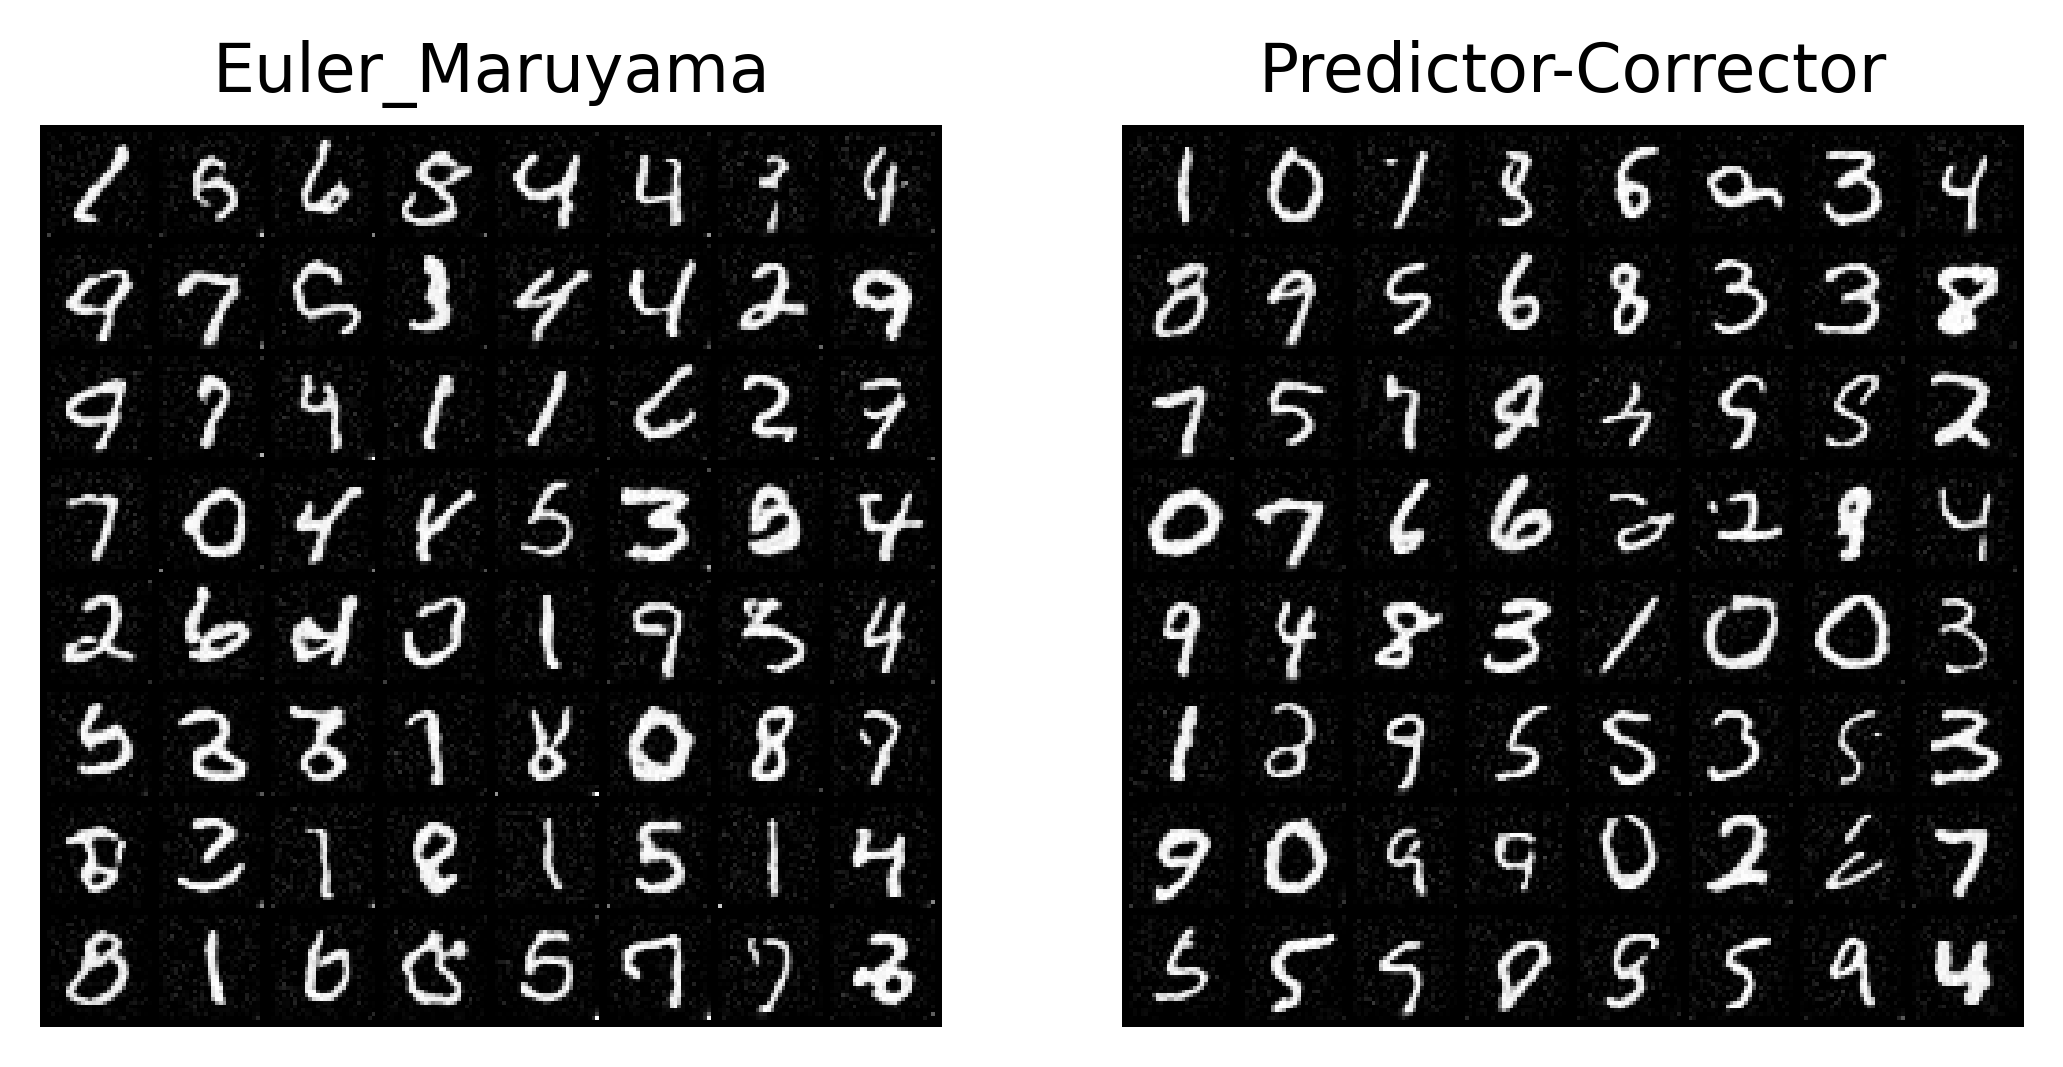

In [31]:
plt.figure(dpi=400)
plt.subplot(121), plt.imshow(im_euler), plt.axis('off'), plt.title('Euler_Maruyama')
plt.subplot(122), plt.imshow(im_pc), plt.axis('off'), plt.title('Predictor-Corrector')